In [168]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

import plotly.figure_factory as ff

In [169]:
trees = pd.read_csv('data/black_spruce.csv')

In [170]:
trees['status_0_1'] = (trees['status'] == 'fallen').astype(int)

In [171]:
splits = [4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 20, 25, 32]
tree_bins = (
    trees["status_0_1"]
    .groupby(pd.cut(trees["diameter"], splits))
    .agg(["mean", "count"])
    .rename(columns={"mean": "proportion"})
    .assign(diameter=lambda df: [i.right for i in df.index])
)

In [172]:
fig = px.scatter(
    tree_bins, x="diameter", y="proportion", size="count",
    labels={"diameter": "Tree Diameter (cm)", "proportion": "Proportion Down"},
    width=450, height=250,
)

# Modeling Proportions (and Probabilities)

Recall that when we model, we need to choose three things: a model, a loss function, and a method to minimize the average loss on our training set. In the previous section, we chose a constant model, the 0-1 loss, and a proof to fit the model. However, the constant model doesn't incorporate predictor variables.
In this section, we address this issue by introducing a new model called the *logistic* model.

To motivate these models, notice that the relationship between tree diameter and the proportion of downed trees does not appear linear. For demonstration, let's fit a simple linear model to these data to show that it has several undesirable features.

Using the techniques from {numref}`Chapter %s <ch:linear>`, we fit a linear model of tree status to diameter:

In [174]:
from sklearn.linear_model import LinearRegression
X = trees[['diameter']]
y = trees['status_0_1']

lin_reg = LinearRegression().fit(X, y)

Then we add this fitted line to our scatter plot of proportions: 

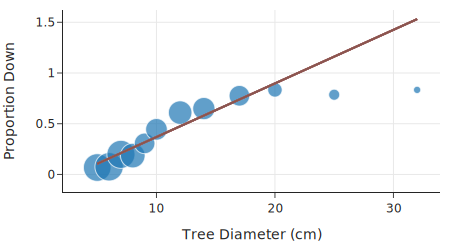

In [187]:
X_plt = pd.DataFrame(
    {"diameter": np.linspace(X["diameter"].min(), X["diameter"].max(), 10)}
)

fig.add_trace(
    go.Scatter(x=X_plt['diameter'], y=lin_reg.predict(X_plt), mode="lines")
)

fig.update_layout(showlegend=False)
fig.show()

Clearly, the model doesn't fit the proportions well at all. There are several problems:

+ The model gives proportions greater than 1 for large trees.
+ The model doesn't pick up the curvature in the proportions.
+ An extreme point (such as a tree that's 30 cm across) shifts the fitted line to the right, away from the bulk of the data.  

To address these issues, we introduce the *logistic model*.

## A Logistic Model 

The logistic model is one of the most widely used basic models for classification and a simple extension of the linear model. The *logistic function*, often called the *sigmoid function*, is defined as: 

$$
\textbf{logistic}(t) = \frac{1}{1+\exp(-t)}
$$

:::{warning}

The *sigmoid* function is typically denoted by $\sigma(t)$. Sadly, the Greek letter $\sigma$ is widely used to mean a lot of things in data science and statistics, like the standard deviation, logistic function, and a permutation. You'll have to be careful when seeing $ \sigma $ and use context to understand its meaning.

:::

We can plot the logistic function to reveal it's s-shape (sigmoid-shape) and confirm that it outputs numbers between 0 and 1. The function monotonically increases with $ t $, and large values of $ t $ get close to 1:

In [190]:
def logistic(t):
    return 1. / (1. + np.exp(-t))

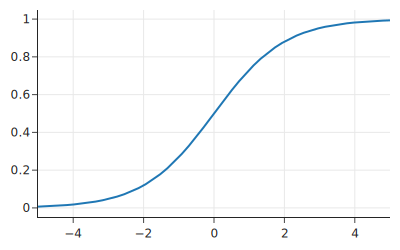

In [191]:
t = np.linspace(-5, 5, 50)
sigmoid_line = go.Scatter(
    name="Logistic Function", x=t, y=logistic(t), mode="lines"
)

fig = go.Figure([sigmoid_line])
fig.update_layout(width=400, height=250)
fig

Since the logistic function maps to the interval between 0 and 1, it is commonly used when modeling proportions and probabilities. Also, we can write the logistic as a function of a line, $\theta_0 + \theta_1 x$:

$$
\sigma\left(\theta_0 + \theta_1 x\right) = \frac{1}{1+\exp(-\theta_0 - \theta_1 x)}
$$

To help build your intuition for the shape of this function, the following plot shows the logistic function as we vary $\theta_0$ and $\theta_1$:

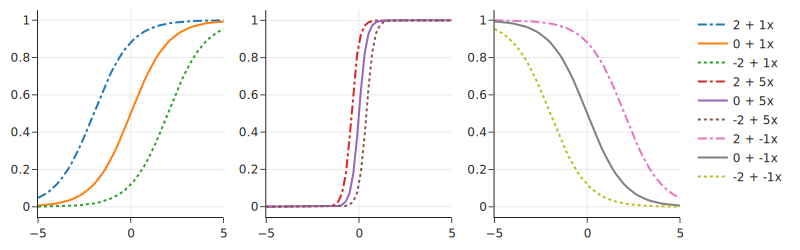

In [195]:
fig = make_subplots(rows=1, cols=3)

from itertools import cycle
styles = cycle(['dashdot', None, 'dot'])

row = col = 1
for theta1 in [1, 5, -1]:
    for theta0 in [2, 0, -2]:
        fig.add_trace(go.Scatter(name=f"{theta0} + {theta1}x", 
                                 x=t, y=logistic(theta0 + theta1*t),
                                 mode="lines", line=dict(dash=next(styles))),
                      row=row, col=col)
    col += 1
        
fig.update_layout(width=800, height=250)        
fig

We can see that changing the magnitude of $ {\theta}_1 $ changes the sharpness of the curve; the further away from 0, the steeper the curve. Flipping the sign of $ {\theta}_1 $ reflects the curve about the vertical line $x=0$. Changing $ \theta_0 $ shifts the curve left and right.

The logistic function can be seen as a transformation: it transforms a linear function into a nonlinear smooth curve, and the output always lies between 0 and 1. In fact, the output of a logistic function has a deeper probabilistic interpretation, which we describe next.

## Log Odds
            
Recall the odds are the ratio, $p/(1-p)$ for a probability $ p $. For example, when we toss a fair coin, the odds of getting heads is 1, and for a coin that's twice as likely to land heads as tails ($p=2/3$), the odds of getting heads is 2. The logistic model is also called the *log odds* model because the logistic function coincides with a linear function of the log odds.

We can see this in the following equations. To show this, we multiply the numerator and denominator of the sigmoid function by $\exp(t)$ 

$$
\begin{aligned}
\sigma(t) & = \frac{1}{1+\exp(-t)} = \frac{\exp(t)}{1+\exp(t)} \\ 
\\
(1-\sigma(t)) & = 1 - \frac{\exp(t)}{1+\exp(t)} = \frac{1}{1+\exp(t)}
\end{aligned}
$$

Then, we take the logarithm of the odds and simplify:

$$
\begin{aligned}
\log \left( \frac{\sigma(t)}{1-\sigma(t)} \right) & = \log(\exp{(t)}) = t\\
\end{aligned}
$$

So, for $\sigma(\theta_0 + \theta_1x)$, we find the log odds is a linear function of $x$:

$$
\begin{aligned}
\log \left( \frac{\sigma(\theta_0 + \theta_1x)}{1-\sigma(\theta_0 + \theta_1x)} \right) & = \log(\exp{(\theta_0 + \theta_1x)}) = \theta_0 + \theta_1x\\
\end{aligned}
$$

This representation of the logistic in terms of log odds gives a useful interpretation for the coefficient $\theta_1$. Suppose the explanatory variable increases by 1. Then the odds change as follows:

$$
\begin{aligned}
\text{ odds } =& ~ \exp\left( \theta_0 + \theta_1(x+1) \right)\\
 =& ~ \exp(\theta_1) \times \exp{(\theta_0 + \theta_1x)}
\end{aligned}
$$

We see that the odds increase or decrease by a factor of $ \exp(\theta_1) $.

:::{note}

Here, the $\log$ function is the natural logarithm. Since the natural log is the
default in data science, we typically don't bother to write it as $\ln$.

:::

Next, let's add a logistic curve to our plot of proportions to get a sense of how well it might fit the data.

## Using a Logistic Curve

In the plot below, we've added a logistic curve on top of the plot of proportions of fallen trees:

In [205]:
from sklearn.linear_model import LogisticRegression

trees = trees.assign(log_diam=np.log(trees['diameter']))
X = trees[['log_diam']]
y = trees['status_0_1']

lr_model = LogisticRegression().fit(X, y)

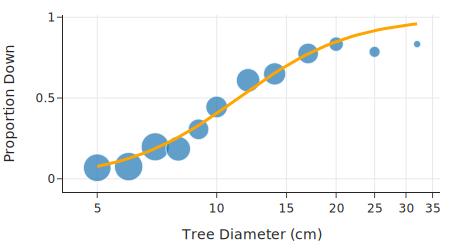

In [209]:
X_plt = pd.DataFrame(
    {"log_diam": np.linspace(X["log_diam"].min(), X["log_diam"].max(), 50)}
)
p_hats = lr_model.predict_proba(X_plt)
X_orig = np.exp(X_plt)

fig = px.scatter(
    tree_bins, x="diameter", y="proportion", size="count", log_x=True,
    labels={"diameter": "Tree Diameter (cm)", "proportion": "Proportion Down"},
    width=450, height=250,
)

fig.add_trace(go.Scatter(
    x=X_orig["log_diam"], y=p_hats[:, 1], line=dict(color="orange", width=3),
))

fig.update_layout(showlegend=False)
fig

We can see that the curve follows the proportions reasonably well. In fact, we selected this particular logistic by fitting it to the data. The fitted logistic regression is:

In [25]:
[t0] = lr_model.intercept_
[[t1]] = lr_model.coef_
print(f'σ({t0:.1f} + {t1:.1f}x)')

σ(-7.4 + 3.0x)


Now that we've seen that logistic curves can model probabilities well, we turn
to the process of fitting logistic curves to data. In the next section, we
proceed to our second step in modeling: selecting an appropriate loss function.